In [231]:
import numpy as np
import random
import gurobipy as gp
from gurobipy import GRB

In [232]:
def MaxMinDiversity(subset: np.ndarray, complete: np.ndarray) -> float:
    """
    Calculate Max-Min Diversity, the minimum distance between all pairs of points in the given subset.
    
    Parameters:
        subset: Subset of points
        complete: Complete graph adjacency matrix containing distances between all pairs of points
    
    Returns:
        min_dist: Max-Min Diversity, the minimum distance between all pairs of points in the subset
    """
    if len(subset) < 2:
        return 0
    
    n = len(subset)
    min_dist = float('inf')
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = complete[subset[i]][subset[j]]
            min_dist = min(min_dist, dist)
    
    return min_dist

In [233]:
def FairRadius(k: int, complete: np.ndarray) -> np.ndarray:
    """
    Calculate Fair Radius for all points in the dataset.

    Parameters:
        k: Integer parameter k, used to calculate minimum number of points each point needs to cover ⌈n/k⌉
        complete: Complete graph adjacency matrix representing distances between all pairs of points
        
    Returns:
        fair_radius: Fair Radius for all points in the dataset
    """
    n = len(complete)
    min_points = int(np.ceil(n / k))
    fair_radius = []

    for i in range(n):
        distances = complete[i]
        sorted_distances = np.sort(distances)
        point_radius = sorted_distances[min_points-1]
        fair_radius.append(point_radius)
        
    return np.array(fair_radius)


In [234]:
def CriticalRegion(alpha: float, fair_radius: np.ndarray, complete: np.ndarray) -> tuple[np.ndarray, dict]:
    """
    Generate the Critical Regions by finding a set of centers that cover all points.
    
    Parameters:
        alpha: Fairness parameter
        fair_radius: Array containing fair radius values for all points
        complete: Complete graph adjacency matrix representing distances between all pairs of points
        
    Returns:
        selected_centers: Centers of critical regions
        critical_regions: Dictionary mapping each center to its covered points
    """
    covered_points = set()
    n = len(fair_radius)
    points = set(range(n))
    selected_centers = []
    critical_regions = {}

    while covered_points != points:
        minus = points - covered_points
        c = min(minus, key=lambda x: fair_radius[x])
        selected_centers.append(c)
        for point in minus:
            if complete[point][c] <= 2 * alpha * fair_radius[point]:
                covered_points.add(point)
        print(len(covered_points))
    selected_centers = np.array(selected_centers)

    for center in selected_centers:
        r_c = fair_radius[center]
        distances = complete[center]
        points_in_circle = np.array([i for i, dist in enumerate(distances) if dist <= alpha * r_c])
        critical_regions[center] = points_in_circle

    return selected_centers, critical_regions


In [235]:
def IFDM(k: int, alpha: float, complete: np.ndarray, epsilon: float, beta: float, selected_centers: np.ndarray, critical_regions: dict) -> tuple[np.ndarray, tuple[tuple[np.ndarray, int], ...], np.ndarray, dict]:
    """
    Construct an instance of k-clustering under partition matroid constraint corresponding to the given instance of alpha-fair k-clustering.
    
    Parameters:
        k: Target number of clusters
        alpha: Fairness parameter
        complete: Complete graph adjacency matrix with distances
        epsilon: Accuracy parameter (< 1/2)
        beta: Approximation guarantee parameter (≤ 1)
        selected_centers: Centers of critical regions
        critical_regions: Dictionary mapping centers to covered points
        
    Returns:
        P_prime: Augmented point set with duplicated points
        centers_info: Tuple containing center selection info
        d_prime: Modified graph adjacency matrix with distances
        corresponding: The dictionary for get the corresponding point in originial data
    """
    n = len(complete)
    P_0 = list(range(n))
    P_1 = list(range(n))
    current_max_id = n
    
    B_copies = {}
    corresponding = {}
    for center in selected_centers:
        copies = []
        for point in critical_regions[center]:
            corresponding[current_max_id] = point
            copies.append(current_max_id)
            P_1.append(point)
            current_max_id += 1
        B_copies[center] = np.array(copies)

    P_prime = np.arange(current_max_id)
    
    k_i = {center: 1 for center in selected_centers}
    
    k_0 = k - len(selected_centers)

    delta = float('inf')
    for i in range(n):
        for j in range(i+1, n):
            if complete[i][j] > 0:
                delta = min(delta, complete[i][j])

    n_prime = len(P_prime)
    d_prime = np.zeros((n_prime, n_prime))

    for i in range(n_prime):
        for j in range(n_prime):
            if i == j:
                d_prime[i][j] = 0
            elif P_1[i] != P_1[j]:
                d_prime[i][j] = complete[P_1[i]][P_1[j]]
            else:
                d_prime[i][j] = epsilon * beta * delta
                
    return P_prime, ((P_0, k_0), *((B_copies[c], k_i[c]) for c in selected_centers)), d_prime, corresponding


In [236]:
def distancePS(centerSet: np.ndarray, i: int, complete: np.ndarray) -> float:
    """
    Returns the distance between a certain point and a certain set.
    
    Parameters:
        centerSet: A numpy array containing confirmed center indexes
        i: The index of any point
        complete : Complete graph adjacency matrix containing distances between all pairs of points
    
    Returns:
        min_distance: The distance between point and center set
    """
    min_distance = float("inf")
    for center in centerSet:
        distance = complete[center][i]
        if (distance < min_distance):
            min_distance = distance
    
    return min_distance

In [237]:
def GMM(points_index: np.ndarray, k: int, complete: np.ndarray) -> np.ndarray:
    """
    Returns indexes of k centers after running GMM Algorithm.
    
    Parameters: 
        points_index: The indexes of data
        k: A decimal integer, the number of centers
        complete: Complete graph adjacency matrix containing distances between all pairs of points
        initial: An initial set of elements
    
    Returns:
        centers: A numpy array with k indexes as center point indexes
    """
    centers = []
    initial_point_index = random.choice(points_index)
    centers.append(initial_point_index)
    while (len(centers) < k):
        max_distance = 0
        max_distance_vector_index = None
        for i in points_index:
            distance = distancePS(centers, i, complete)
            if distance > max_distance:
                max_distance = distance
                max_distance_vector_index = i
        centers.append(max_distance_vector_index)
    centers = np.array(centers)

    return centers

In [238]:
def ILP(n, E, k, color_constraints, color_sets):
    model = gp.Model("ILP")

    x = model.addVars(n, vtype=GRB.BINARY, name="x")

    model.setObjective(gp.quicksum(x[i] for i in range(n)), GRB.MAXIMIZE)

    for (i, j) in E:
        model.addConstr(x[i] + x[j] <= 1, f"edge_{i}_{j}")

    model.addConstr(gp.quicksum(x[i] for i in range(n)) <= k, "max_selection")

    for c, number in color_constraints.items():
        nodes_in_color = color_sets[c]
        print(nodes_in_color)
        model.addConstr(gp.quicksum(x[i] for i in nodes_in_color) == number, f"number_color_{c}")

    model.optimize()

    if model.status == GRB.OPTIMAL:
        selected_nodes = np.array([i for i in range(n) if x[i].x > 0.5])
        return selected_nodes
    else:
        raise ValueError("No optimal solution found.")
        

In [239]:
def FMMDS(sets: tuple, k: int, error: float, complete: np.ndarray) -> np.ndarray:
    """
    Returns a subset with high Max-min diversity under partition matroid constraint.
    
    Parameters:
        sets: A tuple containing partitioned sets returned by IFDM function
        k: A decimal integer, the number of elements to be selected
        error: A float number indicating the error parameter
        complete: Complete graph adjacency matrix containing distances between all pairs of points
    
    Returns:
        solution: A numpy array containing selected elements that maximize the minimum pairwise distance
    """
    amount = complete.shape[0]
    complete_array = np.arange(amount)
    U_gmm = GMM(complete_array, k, complete)
    critical_number = len(sets)
    U_c = []
    for i in range(critical_number):
        U_c.append(np.intersect1d(sets[i][0], U_gmm))
    distance_p = 2 * MaxMinDiversity(U_gmm, complete)
    print(U_c)

    S = []
    while len(S) == 0:
        for c in range(critical_number):
            while len(U_c[c]) < k and any(v for v in sets[c][0] if MaxMinDiversity(np.union1d(U_c[c], [v]), complete) >= distance_p):
                max_distance = 0
                max_distance_vector_index = None
                for i in sets[c][0]:
                    distance = distancePS(U_c[c], i, complete)
                    if distance > max_distance:
                        max_distance = distance
                        max_distance_vector_index = i
                U_c[c] = np.append(U_c[c], max_distance_vector_index)

        V_p = np.concatenate(U_c)
        E = []
        for i in range(len(V_p)):
             for j in range(i + 1, len(V_p)):
                  if complete[V_p[i]][V_p[j]] < distance_p / 2:
                       E.append((V_p[i], V_p[j]))

        color_constraints = dict()
        color_sets = dict()
        for group in range(critical_number):
            color_constraints[group] = sets[group][1]
            color_sets[group] = sets[group][0]
        
        solution = ILP(amount, E, k, color_constraints, color_sets)
        if len(solution) < k:
             distance_p = (1 - error) * distance_p
        else:
             S = solution
    return S

In [240]:
def SOL(S: np.ndarray, corresponding: dict, complete: np.ndarray):

    solution = []
    for point in S:
        if point < complete.shape[0]:
            solution.append(point)
        else:
            solution.append(corresponding[point])
    solution = np.array(solution)

    return solution

In [241]:
def G(points: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns the adjacency matrix of n points and the list of edges.
    Args: 
        points (np.ndarray): The dataset, a list with n points
    Returns:
        complete (np.ndarray): The adjacency matrix of n points.
        edges (np.ndarray): The list of edges.
    """
    length = points.shape[0]
    complete = np.zeros((length, length))
    edges = []
    for k, point_k in enumerate(points):
        for j, point_j in enumerate(points):
            distance_kj = np.linalg.norm(point_k - point_j)
            complete[k][j] = distance_kj
            if (j > k):
                edges.append(distance_kj)
    edges.sort()
    edges = np.array(edges)
    return complete, edges

人造数据集测试！

In [242]:
import math
import matplotlib.pyplot as plt

In [243]:
# ============
# Generate datasets
# ============
np.random.seed(434)
n_samples = 1500 # sample size
z = 1000

# ============
# Definitions of Functions
# ============
def mat_sqrt(Mat):
    eig_value,eig_vec = eig(Mat)
    return(eig_vec.dot(np.diag(np.sqrt(eig_value)).dot(eig_vec.T)))

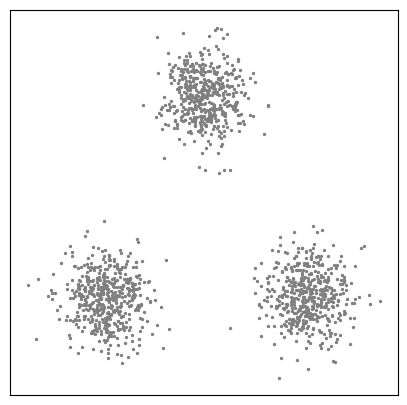

In [244]:
## Case One : Simple Case (Equal Variance and Equal Size)
K = 30
n_subset = int(n_samples/3)
z1 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))
z2 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))
z3 = np.random.normal(loc = 0, scale = 0.3,size = (n_subset,2))

mu1 = np.array([0,1])
mu2 = np.array([-math.sqrt(2),-math.sqrt(2)])
mu3 = np.array([math.sqrt(2),-math.sqrt(2)])

true_labels_1 = []
x11 = z1 + mu1
x12 = z2 + mu2
x13 = z3 + mu3
dataset1 = np.r_[x11,x12,x13]
for i in range(len(x11)):
    true_labels_1.append(0)
for i in range(len(x12)):
    true_labels_1.append(1)
for i in range(len(x13)):
    true_labels_1.append(2)

fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x11[:,0],x11[:,1],color="grey",s = 2)
plt.scatter(x12[:,0],x12[:,1],color="grey",s = 2)
plt.scatter(x13[:,0],x13[:,1],color="grey",s = 2)

In [245]:
dataset1.shape

(1500, 2)

In [246]:
complete, edges = G(dataset1)


In [247]:
complete.shape

(1500, 1500)

In [248]:
points = np.arange(dataset1.shape[0])
points

array([   0,    1,    2, ..., 1497, 1498, 1499])

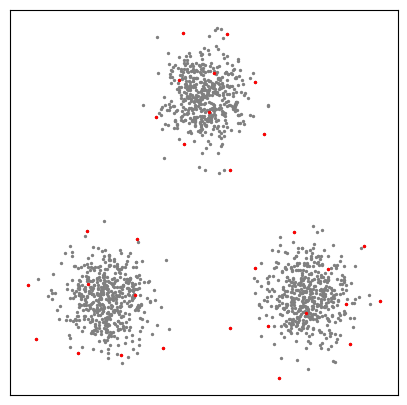

In [249]:
b = GMM(points, K, complete)
a = list(b)
for i in range(len(a)):
    a[i] = list(dataset1[b[i]])
a = np.array(a)
fig = plt.figure(figsize = [5,5])
ax = fig.add_subplot(1,1,1)
plt.xticks(())
plt.yticks(())
plt.scatter(x11[:,0],x11[:,1],color="grey",s = 2)
plt.scatter(x12[:,0],x12[:,1],color="grey",s = 2)
plt.scatter(x13[:,0],x13[:,1],color="grey",s = 2)
plt.scatter(a[:,0], a[:,1], color="red", s = 2)

In [250]:
MaxMinDiversity(b, complete)

0.48587022418405523

In [251]:
fairradius = FairRadius(K, complete)
fairradius

array([0.26171399, 0.22509077, 0.25077911, ..., 0.38606186, 0.29102952,
       0.41601625])

In [252]:
critical = CriticalRegion(1, fairradius, complete)
critical[0].shape

331
730
1031
1153
1199
1320
1398
1453
1499
1500


(10,)

In [253]:
critical[0]

array([ 119, 1360,  603,    5,  454,  894,  973, 1258, 1388,  312])

In [254]:
critical[1]

{119: array([  3,  17,  39,  44,  50,  58,  69,  70,  77,  79,  81,  83,  86,
         89,  93,  97, 119, 134, 148, 151, 178, 182, 183, 186, 193, 198,
        214, 232, 236, 270, 282, 283, 299, 301, 338, 341, 347, 353, 357,
        368, 382, 397, 403, 413, 427, 443, 459, 463, 491, 494]),
 1360: array([1010, 1013, 1014, 1022, 1037, 1045, 1047, 1049, 1056, 1068, 1069,
        1073, 1093, 1108, 1114, 1126, 1143, 1148, 1158, 1176, 1180, 1200,
        1232, 1246, 1247, 1261, 1271, 1279, 1299, 1300, 1303, 1326, 1343,
        1345, 1352, 1360, 1370, 1405, 1421, 1422, 1423, 1424, 1431, 1432,
        1443, 1444, 1446, 1447, 1471, 1496]),
 603: array([556, 561, 566, 569, 586, 588, 589, 603, 609, 610, 618, 641, 645,
        656, 678, 696, 700, 701, 707, 721, 726, 730, 738, 750, 752, 759,
        763, 779, 788, 813, 814, 824, 832, 847, 848, 851, 871, 876, 886,
        896, 904, 906, 908, 911, 918, 942, 943, 960, 975, 982]),
 5: array([  5,  14,  15,  16,  20,  21,  25,  65,  66,  71,  73,  85,  92

In [255]:
ifdm = IFDM(K, 1, complete, 0.05, 1, critical[0], critical[1])

In [256]:
ifdm[0].shape

(2000,)

In [257]:
ifdm[2].shape

(2000, 2000)

In [258]:
solution = FMMDS(ifdm[1], K, 0.05, ifdm[2])

[array([   7,   19,   68,  117,  128,  160,  172,  208,  414,  513,  553,
        563,  624,  628,  651,  655,  725,  736,  822, 1018, 1067, 1185,
       1217, 1262, 1332, 1358, 1392, 1413, 1462]), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([1757]), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 

In [259]:
solution

array([ 480,  481,  482,  483,  484,  485,  486,  487,  488,  489,  490,
        491,  492,  493,  494,  495,  496,  497,  498,  499, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950])

In [260]:
MaxMinDiversity(solution, ifdm[2])

0.024494390049112726

In [261]:
real_sol = SOL(solution, ifdm[3], complete)

In [262]:
MaxMinDiversity(real_sol, complete)

0.024494390049112726